# Ghidra_bench study

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np

## Dependencies and dataset

In [59]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics_gh.csv'
REPORTS_PATH = './ghidra_bench/outputs/reports/*.json'

In [60]:
def load_metrics(path):
    try:
        df = pd.read_csv(path)     
        df = df.drop(columns=df.columns[:2])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    return df

df_metrics = load_metrics(LOGS_PATH)

print(f"Loaded {len(df_metrics)} hardware metric records.")
df_metrics.head()

Loaded 1111 hardware metric records.


,model_id,operation,duration_sec,peak_vram_gb,system_ram_gb,prompt_tokens,generated_tokens
0,qwen-coder,score,3.4598,7.4449,1.6540,3607,0
1,qwen-coder,score,1.6956,7.4449,1.6554,3607,0
2,qwen-coder,generate,4.6181,6.6296,2.0193,7617,38
3,qwen-coder,score,4.4368,7.4479,1.6593,3607,0
4,qwen-coder,score,2.2021,7.4479,1.6610,3607,0


# LLM

## Time LLM study

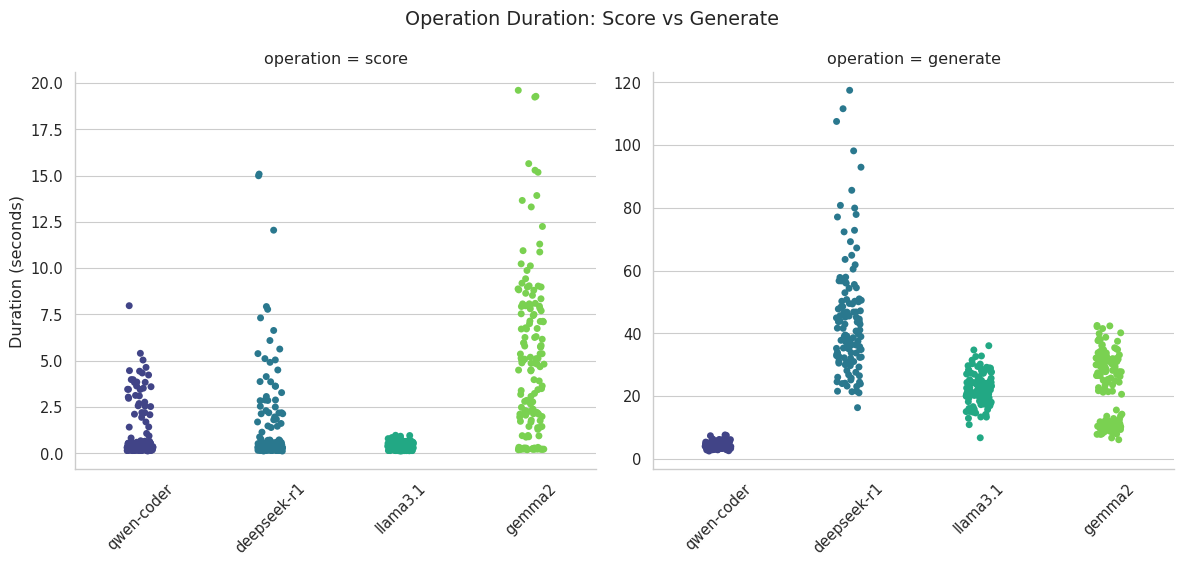

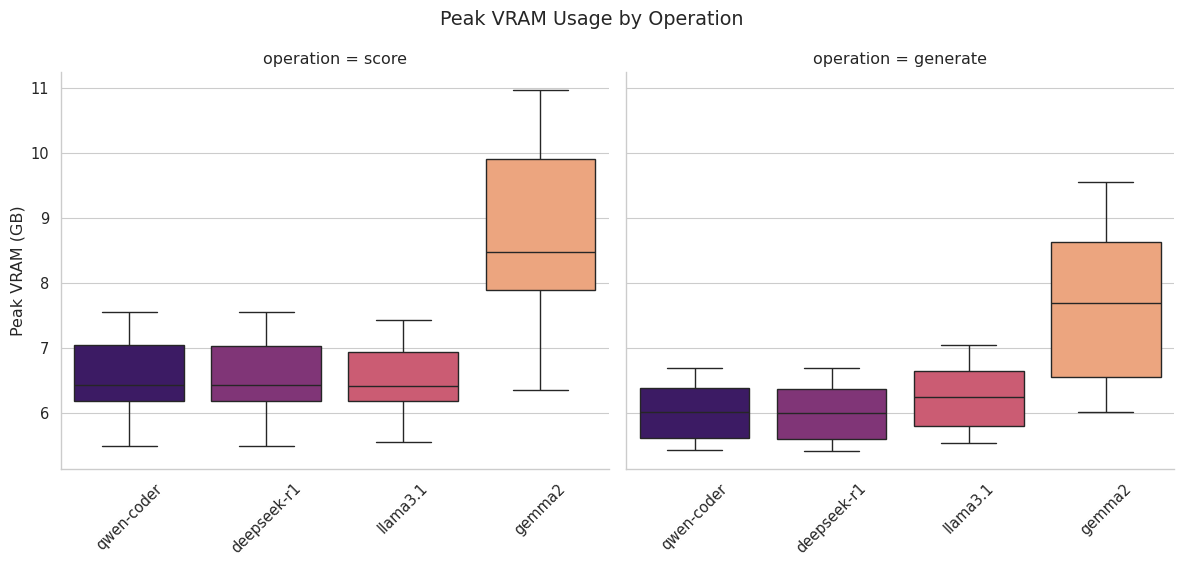

In [72]:
if not df_metrics.empty:
    g = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='duration_sec', 
        col='operation',  # split for 'score' and 'generate'
        kind='strip', #'box',
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2,
        sharey=False      # Independent Y-axis
    )
    g.figure.suptitle('Operation Duration: Score vs Generate', y=1.05)
    g.set_axis_labels("", "Duration (seconds)")
    g.set_xticklabels(rotation=45)
    
    g_vram = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='peak_vram_gb',
        col='operation',
        kind='box', 
        hue='model_id', 
        palette='magma', 
        height=5, 
        aspect=1.2
    )
    g_vram.figure.suptitle('Peak VRAM Usage by Operation', y=1.05)
    g_vram.set_axis_labels("", "Peak VRAM (GB)")
    g_vram.set_xticklabels(rotation=45)
    # for ax in g_vram.axes.flat:
    #     ax.axhline(16, color='red', linestyle='--', linewidth=2, label='Limit VRAM')
        

    plt.show()
else:
    print("No metrics data found.")

## Generation study

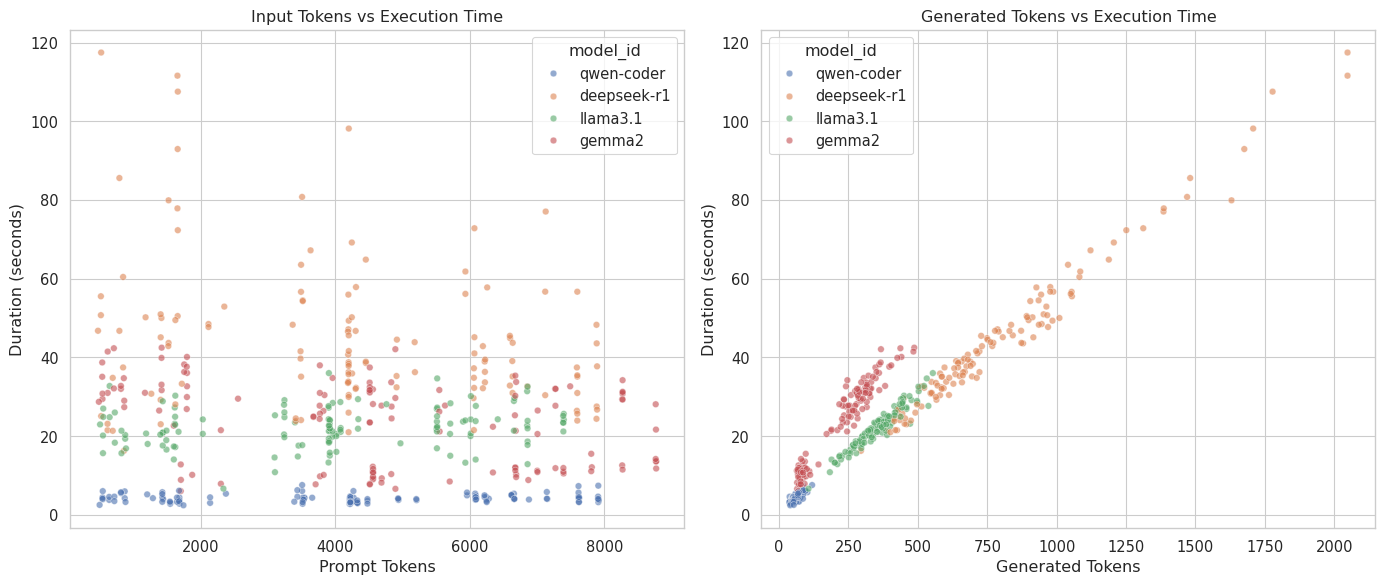

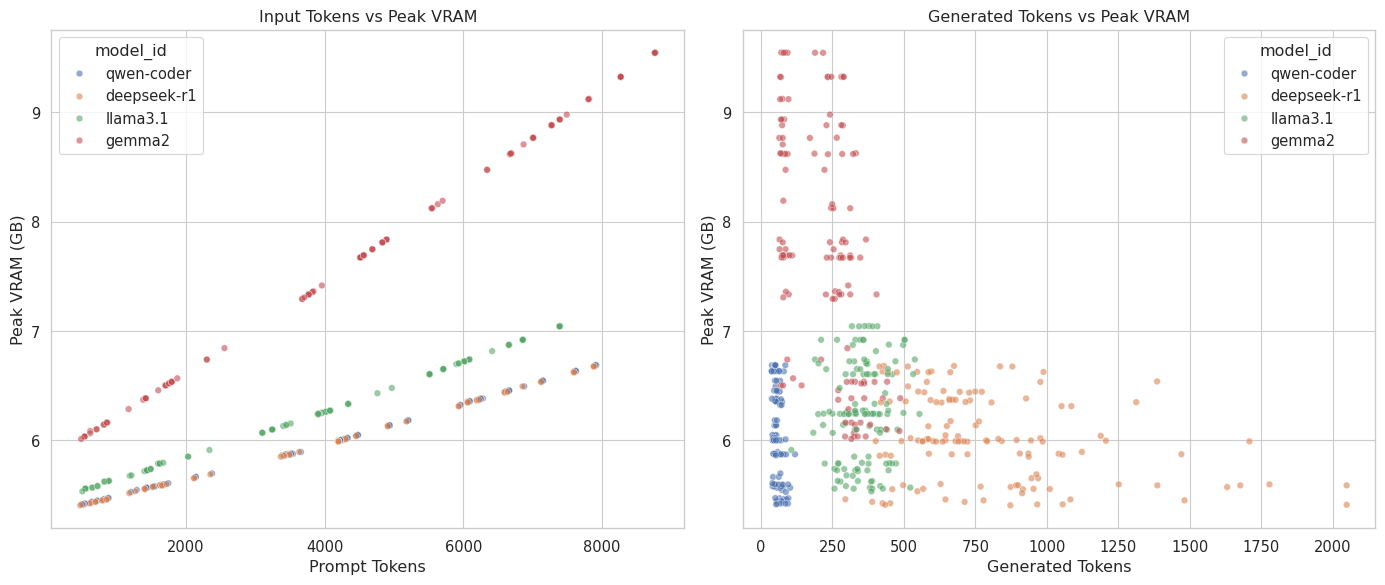

In [62]:
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Execution Time')
plt.xlabel('Generated Tokens')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Peak VRAM')
plt.xlabel('Generated Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.tight_layout()
plt.show()



## Score study

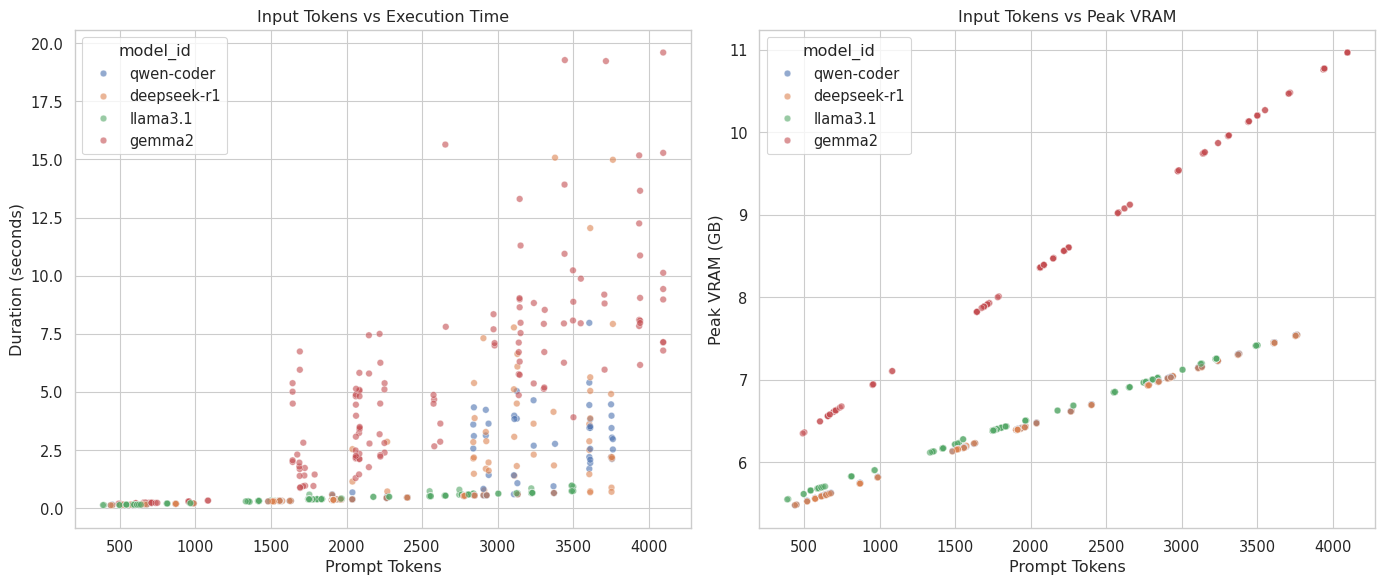

In [63]:
df_gen = df_metrics[df_metrics['operation'] == 'score'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')


plt.tight_layout()
plt.show()

# Reports study

### Generation humanity

In [64]:
def load_reports(path_pattern):
    report_files = glob.glob(path_pattern)
    
    clean_data = []
    model_stats = {}

    def update_stat(model, stat_type):
        if model not in model_stats:
            model_stats[model] = {'unknown_winner': 0, 'llm_error': 0, 'valid': 0}
        model_stats[model][stat_type] += 1

    for file in report_files:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'Unknown')
            results_dict = data.get('results', {})
            
            for model_name, function_list in results_dict.items():
                if not isinstance(function_list, list):
                    continue
                    
                for entry in function_list:
                    if not isinstance(entry, dict):
                        continue

                    llm_qualitative = entry.get('llm_qualitative', {})
                    #llm_ast = entry.get('llm_ast', {}) 

                    if 'error' in llm_qualitative:
                        update_stat(model_name, 'llm_error')
                        continue

                    winner = llm_qualitative.get('winner')
                    if winner == 'Unknown':
                        update_stat(model_name, 'unknown_winner')
                        continue
                    if winner == 'Error':
                        update_stat(model_name, 'llm_error')
                        continue
                    
                        
                    # Valid
                    metrics = entry.get('metrics', {})
                    row = {
                        'pr': pr_number,
                        'model': model_name,
                        'binary': entry.get('binary', 'N/A'),
                        'function': entry.get('function', 'Unknown'),
                        'base_ppl': metrics.get('base_ppl'),
                        'pr_ppl': metrics.get('pr_ppl'),
                        'delta_ppl': metrics.get('delta_ppl'),
                        'winner': winner,
                        #'winner_ast': llm_ast.get('winner')
                    }
                    clean_data.append(row)
                    update_stat(model_name, 'valid')
                    
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            
    return pd.DataFrame(clean_data), pd.DataFrame(model_stats).T

df_reports, df_stats = load_reports(REPORTS_PATH)
    
display(df_stats)
df_reports.head()

,unknown_winner,llm_error,valid
qwen-coder,0,0,107
deepseek-r1,1,1,105
llama3.1,29,60,18
gemma2,0,3,104


,pr,model,binary,function,base_ppl,pr_ppl,delta_ppl,winner
0,7253,qwen-coder,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,2.000000,2.015625,0.015625,TIE
1,7253,qwen-coder,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,2.000000,2.015625,0.015625,TIE
2,7253,qwen-coder,task-file_file_signextend-O0.so,file_signextend,2.171875,2.171875,0.000000,TIE
3,7253,qwen-coder,task-file_file_signextend-O2.so,file_signextend,1.757812,1.765625,0.007812,PR
4,7253,qwen-coder,task-file_file_signextend-O3.so,file_signextend,1.757812,1.765625,0.007812,PR


=== Coherence Analysis (Base) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,29,4,0.137931
1,gemma2,32,3,0.093750
2,llama3.1,4,1,0.250000
3,qwen-coder,7,3,0.428571


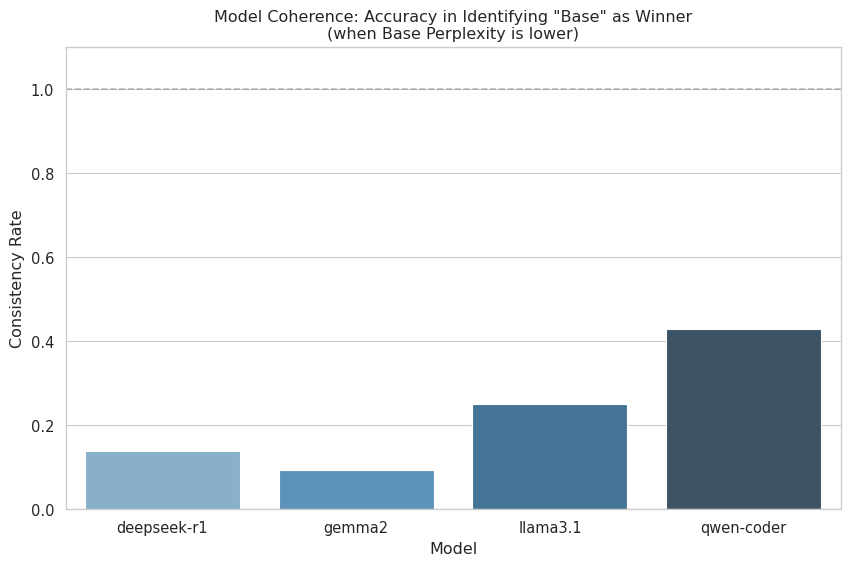

=== Coherence Analysis (PR) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,39,39,1.0
1,gemma2,34,34,1.0
2,llama3.1,6,6,1.0
3,qwen-coder,2,2,1.0


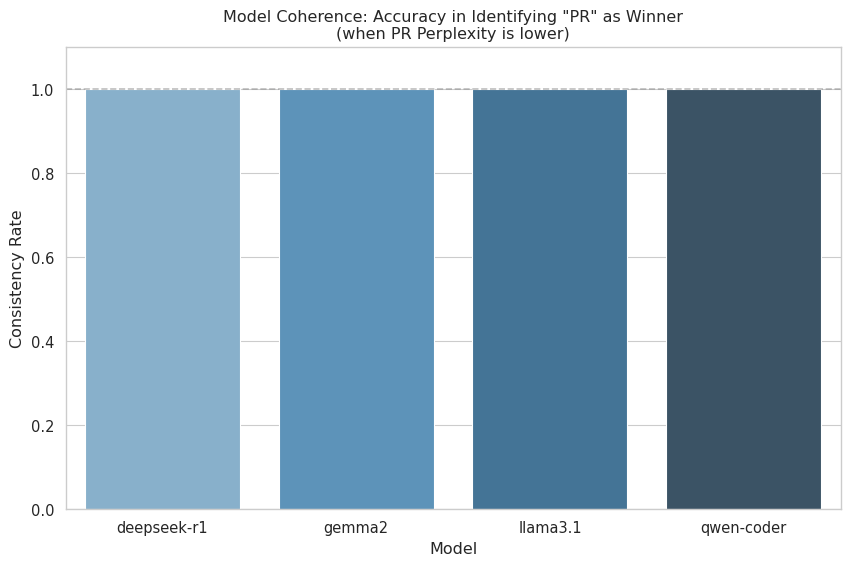

In [65]:
def analyze_coherence(df_reports, title, winner_labels, is_lower):
    if not df_reports.empty:
        
        # Base is better when is_lower is True
        base_better_mask = df_reports['delta_ppl'] > 0 if is_lower else df_reports['delta_ppl'] < 0
        df_consistency = df_reports[base_better_mask].copy()

        df_consistency = df_consistency[
            ~df_consistency['winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
        ]

        valid_base_winners = winner_labels
        
        df_consistency['is_consistent'] = df_consistency['winner'].apply(
            lambda x: any(k in str(x) for k in valid_base_winners)
        )
        
        # Calculate Consistency Rate per Model
        coherence_stats = df_consistency.groupby('model')['is_consistent'].agg(['count', 'sum', 'mean']).reset_index()
        coherence_stats.columns = ['Model', 'Total Cases Win', 'Consistent Winners', 'Consistency Rate']
        
        print(f"=== Coherence Analysis ({'Base' if is_lower else 'PR'}) ===")
        display(coherence_stats)
        
        # Plotting Consistency
        plt.figure(figsize=(10, 6))
        sns.barplot(data=coherence_stats, x='Model', hue='Model', y='Consistency Rate', palette='Blues_d', legend=False)
        plt.title(f'Model Coherence: Accuracy in Identifying {title}')
        plt.ylim(0, 1.1)
        plt.ylabel('Consistency Rate')
        plt.axhline(1.0, linestyle='--', color='grey', alpha=0.5)
        plt.show()


obj = [{
    "title":'"Base" as Winner\n(when Base Perplexity is lower)',
    "winner": ['A', 'Base'],
    "islower": True
},
{
    "title":'"PR" as Winner\n(when PR Perplexity is lower)',
    "winner": ['B', 'PR'],
    "islower": False
}]

for item in obj:
    analyze_coherence(df_reports, item['title'], item['winner'], item['islower'])

In [66]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    df_consistency = df_reports[
        ~df_reports['winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
    ]
    for model in unique_models:
        print(f"\n--- Model: {model} ---")
        df_model = df_consistency[df_consistency['model'] == model]
        df_model = df_model.assign(abs_delta=df_model['delta_ppl'].abs())
        
        top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)
        
        cols = ['pr', 'binary', 'function', 'abs_delta', 'delta_ppl', 'winner']
        
        # Styling the table for readability
        styled_table = top_changes[cols].style.background_gradient(
            subset=['abs_delta'], cmap='RdBu_r'
        ).format({'abs_delta': "{:.4f}"})
        
        display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

--- Model: qwen-coder ---


,pr,binary,function,abs_delta,delta_ppl,winner
17,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.0938,0.093750,BASE
243,8587,task-file_file_replace-O0.so,file_replace,0.0625,-0.062500,BASE
268,6722,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.0312,0.031250,BASE
274,6722,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0156,0.015625,PR
273,6722,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0156,0.015625,PR
11,7253,task-libxls_xls_isRecordTooSmall-O3.so,xls_isRecordTooSmall,0.0156,0.015625,BASE
4,7253,task-file_file_signextend-O3.so,file_signextend,0.0078,0.007812,PR
3,7253,task-file_file_signextend-O2.so,file_signextend,0.0078,0.007812,PR
173,8628,task-readstat_sav_parse_date-O0.so,sav_parse_date,0.0078,-0.007812,BASE
104,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.0000,0.000000,PR



--- Model: deepseek-r1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
284,6722,task-file_file_signextend-O0.so,file_signextend,1.2031,-1.203125,PR
128,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.6562,-0.656250,PR
250,8587,task-file_file_replace-O0.so,file_replace,0.4062,-0.406250,PR
39,7253,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.3125,0.312500,BASE
40,7253,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.3125,0.312500,PR
41,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.2812,0.281250,PR
42,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.2812,0.281250,PR
27,7253,task-file_file_signextend-O0.so,file_signextend,0.2344,0.234375,BASE
196,8628,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.1875,-0.187500,BASE
197,8628,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.1875,-0.187500,PR



--- Model: llama3.1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
308,6722,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.1016,-0.101562,PR
131,6718,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0469,-0.046875,PR
52,7253,task-file_file_signextend-O3.so,file_signextend,0.0391,0.039062,BASE
51,7253,task-file_file_signextend-O2.so,file_signextend,0.0391,0.039062,PR
130,6718,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.0312,0.031250,PR
55,7253,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0312,-0.031250,PR
53,7253,task-readstat_sav_parse_very_long_string_record-O3.so,sav_parse_very_long_string_record,0.0312,-0.031250,PR
50,7253,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0156,0.015625,PR
307,6722,task-readstat_sav_parse_very_long_string_record-O3.so,sav_parse_very_long_string_record,0.0156,-0.015625,PR
54,7253,task-readstat_zsav_read_compressed_data-O0.so,zsav_read_compressed_data,0.0078,-0.007812,BASE



--- Model: gemma2 ---


,pr,binary,function,abs_delta,delta_ppl,winner
312,6722,task-file_file_signextend-O0.so,file_signextend,0.3203,-0.320312,PR
70,7253,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.1094,0.109375,PR
72,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.1094,0.109375,PR
71,7253,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.1094,0.109375,PR
73,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.1094,0.109375,PR
156,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.0781,0.078125,PR
226,8628,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0469,-0.046875,BASE
332,6722,task-xz_lzma_index_hash_decode-O0.so,lzma_index_hash_decode,0.0391,-0.039062,PR
59,7253,task-file_file_signextend-O2.so,file_signextend,0.0312,0.031250,PR
60,7253,task-file_file_signextend-O3.so,file_signextend,0.0312,0.031250,PR


## generation ast study

In [67]:
def load_reports(path_pattern):
    report_files = glob.glob(path_pattern)
    
    clean_data = []
    model_stats = {}

    def update_stat(model, stat_type):
        if model not in model_stats:
            model_stats[model] = {'unknown_winner': 0, 'llm_error': 0, 'valid': 0}
        model_stats[model][stat_type] += 1

    for file in report_files:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'Unknown')
            results_dict = data.get('results', {})
            
            for model_name, function_list in results_dict.items():
                if not isinstance(function_list, list):
                    continue
                    
                for entry in function_list:
                    if not isinstance(entry, dict):
                        continue

                    #llm_qualitative = entry.get('llm_qualitative', {})
                    llm_ast = entry.get('llm_ast', {}) 

                    if 'error' in llm_ast:
                        update_stat(model_name, 'llm_error')
                        continue

                    winner = llm_ast.get('winner')
                    if winner == 'Unknown':
                        update_stat(model_name, 'unknown_winner')
                        continue
                    if winner == 'Error':
                        update_stat(model_name, 'llm_error')
                        continue
                    
                        
                    # Valid
                    metrics = entry.get('metrics', {})
                    row = {
                        'pr': pr_number,
                        'model': model_name,
                        'binary': entry.get('binary', 'N/A'),
                        'function': entry.get('function', 'Unknown'),
                        'base_ppl': metrics.get('base_ppl'),
                        'pr_ppl': metrics.get('pr_ppl'),
                        'delta_ppl': metrics.get('delta_ppl'),
                        'winner': winner,
                        #'winner_ast': llm_ast.get('winner')
                    }
                    clean_data.append(row)
                    update_stat(model_name, 'valid')
                    
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            
    return pd.DataFrame(clean_data), pd.DataFrame(model_stats).T

df_reports, df_stats = load_reports(REPORTS_PATH)
    
display(df_stats)
df_reports.head()

,unknown_winner,llm_error,valid
qwen-coder,0,0,107
deepseek-r1,1,0,106
llama3.1,0,5,102
gemma2,0,1,106


,pr,model,binary,function,base_ppl,pr_ppl,delta_ppl,winner
0,7253,qwen-coder,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,2.000000,2.015625,0.015625,BASE
1,7253,qwen-coder,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,2.000000,2.015625,0.015625,BASE
2,7253,qwen-coder,task-file_file_signextend-O0.so,file_signextend,2.171875,2.171875,0.000000,TIE
3,7253,qwen-coder,task-file_file_signextend-O2.so,file_signextend,1.757812,1.765625,0.007812,TIE
4,7253,qwen-coder,task-file_file_signextend-O3.so,file_signextend,1.757812,1.765625,0.007812,TIE


=== Coherence Analysis (Base) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,9,2,0.222222
1,gemma2,7,0,0.000000
2,llama3.1,3,0,0.000000
3,qwen-coder,7,5,0.714286


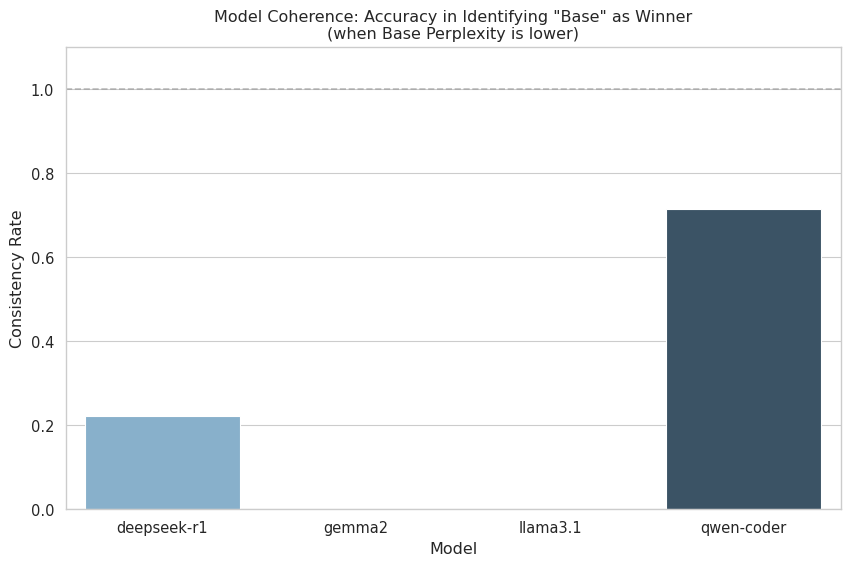

=== Coherence Analysis (PR) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,5,5,1.0
1,gemma2,4,4,1.0
2,llama3.1,8,8,1.0
3,qwen-coder,2,2,1.0


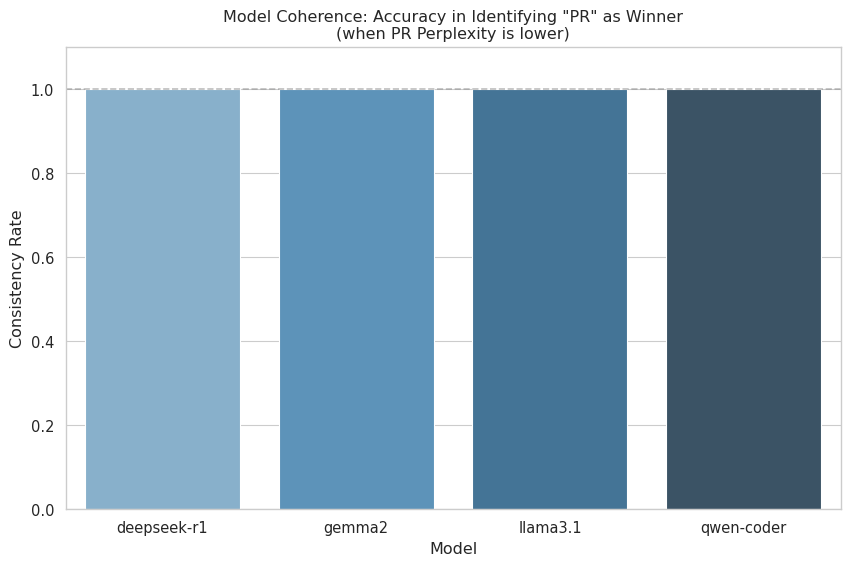

In [68]:
def analyze_coherence(df_reports, title, winner_labels, is_lower):
    if not df_reports.empty:
        
        # Base is better when is_lower is True
        base_better_mask = df_reports['delta_ppl'] > 0 if is_lower else df_reports['delta_ppl'] < 0
        df_consistency = df_reports[base_better_mask].copy()

        df_consistency = df_consistency[
            ~df_consistency['winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
        ]

        valid_base_winners = winner_labels
        
        df_consistency['is_consistent'] = df_consistency['winner'].apply(
            lambda x: any(k in str(x) for k in valid_base_winners)
        )
        
        # Calculate Consistency Rate per Model
        coherence_stats = df_consistency.groupby('model')['is_consistent'].agg(['count', 'sum', 'mean']).reset_index()
        coherence_stats.columns = ['Model', 'Total Cases Win', 'Consistent Winners', 'Consistency Rate']
        
        print(f"=== Coherence Analysis ({'Base' if is_lower else 'PR'}) ===")
        display(coherence_stats)
        
        # Plotting Consistency
        plt.figure(figsize=(10, 6))
        sns.barplot(data=coherence_stats, x='Model', hue='Model', y='Consistency Rate', palette='Blues_d', legend=False)
        plt.title(f'Model Coherence: Accuracy in Identifying {title}')
        plt.ylim(0, 1.1)
        plt.ylabel('Consistency Rate')
        plt.axhline(1.0, linestyle='--', color='grey', alpha=0.5)
        plt.show()


obj = [{
    "title":'"Base" as Winner\n(when Base Perplexity is lower)',
    "winner": ['A', 'Base'],
    "islower": True
},
{
    "title":'"PR" as Winner\n(when PR Perplexity is lower)',
    "winner": ['B', 'PR'],
    "islower": False
}]

for item in obj:
    analyze_coherence(df_reports, item['title'], item['winner'], item['islower'])

In [69]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    df_consistency = df_reports[
        ~df_reports['winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
    ]
    for model in unique_models:
        print(f"\n--- Model: {model} ---")
        df_model = df_consistency[df_consistency['model'] == model]
        df_model = df_model.assign(abs_delta=df_model['delta_ppl'].abs())
        
        top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)
        
        cols = ['pr', 'binary', 'function', 'abs_delta', 'delta_ppl', 'winner']
        
        # Styling the table for readability
        styled_table = top_changes[cols].style.background_gradient(
            subset=['abs_delta'], cmap='RdBu_r'
        ).format({'abs_delta': "{:.4f}"})
        
        display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

--- Model: qwen-coder ---


,pr,binary,function,abs_delta,delta_ppl,winner
0,7253,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,0.0156,0.015625,BASE
1,7253,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0156,0.015625,BASE
338,6722,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0156,0.015625,BASE
11,7253,task-libxls_xls_isRecordTooSmall-O3.so,xls_isRecordTooSmall,0.0156,0.015625,PR
10,7253,task-libxls_xls_isRecordTooSmall-O2.so,xls_isRecordTooSmall,0.0156,0.015625,PR
339,6722,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0156,0.015625,BASE
8,7253,task-readstat_sav_parse_very_long_string_record-O2.so,sav_parse_very_long_string_record,0.0078,0.007812,BASE
6,7253,task-readstat_sav_parse_long_variable_names_record-O2.so,sav_parse_long_variable_names_record,0.0078,-0.007812,BASE
7,7253,task-readstat_sav_parse_long_variable_names_record-O3.so,sav_parse_long_variable_names_record,0.0078,-0.007812,BASE
118,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.0000,0.000000,BASE



--- Model: deepseek-r1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
143,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.6562,-0.656250,BASE
41,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.2812,0.281250,PR
42,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.2812,0.281250,BASE
347,6722,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,0.0938,-0.093750,BASE
25,7253,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,0.0938,0.093750,PR
26,7253,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0938,0.093750,PR
348,6722,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0938,-0.093750,PR
350,6722,task-libxls_xls_parseWorkBook-O0.so,xls_parseWorkBook,0.0625,-0.062500,PR
44,7253,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0469,0.046875,BASE
36,7253,task-libxls_xls_isRecordTooSmall-O3.so,xls_isRecordTooSmall,0.0312,0.031250,PR



--- Model: llama3.1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
62,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.1406,0.140625,PR
61,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.1406,0.140625,PR
388,6722,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.1016,-0.101562,PR
389,6722,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.1016,-0.101562,PR
54,7253,task-readstat_sav_parse_long_variable_names_record-O2.so,sav_parse_long_variable_names_record,0.0312,-0.031250,PR
64,7253,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0312,-0.031250,BASE
65,7253,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0312,-0.031250,PR
375,6722,task-libxls_xls_parseWorkBook-O0.so,xls_parseWorkBook,0.0156,-0.015625,PR
49,7253,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,0.0156,0.015625,PR
373,6722,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0156,-0.015625,PR



--- Model: gemma2 ---


,pr,binary,function,abs_delta,delta_ppl,winner
87,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.1094,0.109375,PR
86,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.1094,0.109375,PR
192,6718,task-file_file_checkfmt-O2.so,file_checkfmt,0.0781,0.078125,PR
80,7253,task-libxls_xls_isRecordTooSmall-O2.so,xls_isRecordTooSmall,0.0234,0.023438,PR
90,7253,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0234,-0.023438,PR
89,7253,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0234,-0.023438,PR
81,7253,task-libxls_xls_isRecordTooSmall-O3.so,xls_isRecordTooSmall,0.0234,0.023438,PR
70,7253,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,0.0156,0.015625,PR
71,7253,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,0.0156,0.015625,PR
93,7253,task-readstat_readstat_parse_por-O0.so,readstat_parse_por,0.0156,-0.015625,PR


## Perplexity

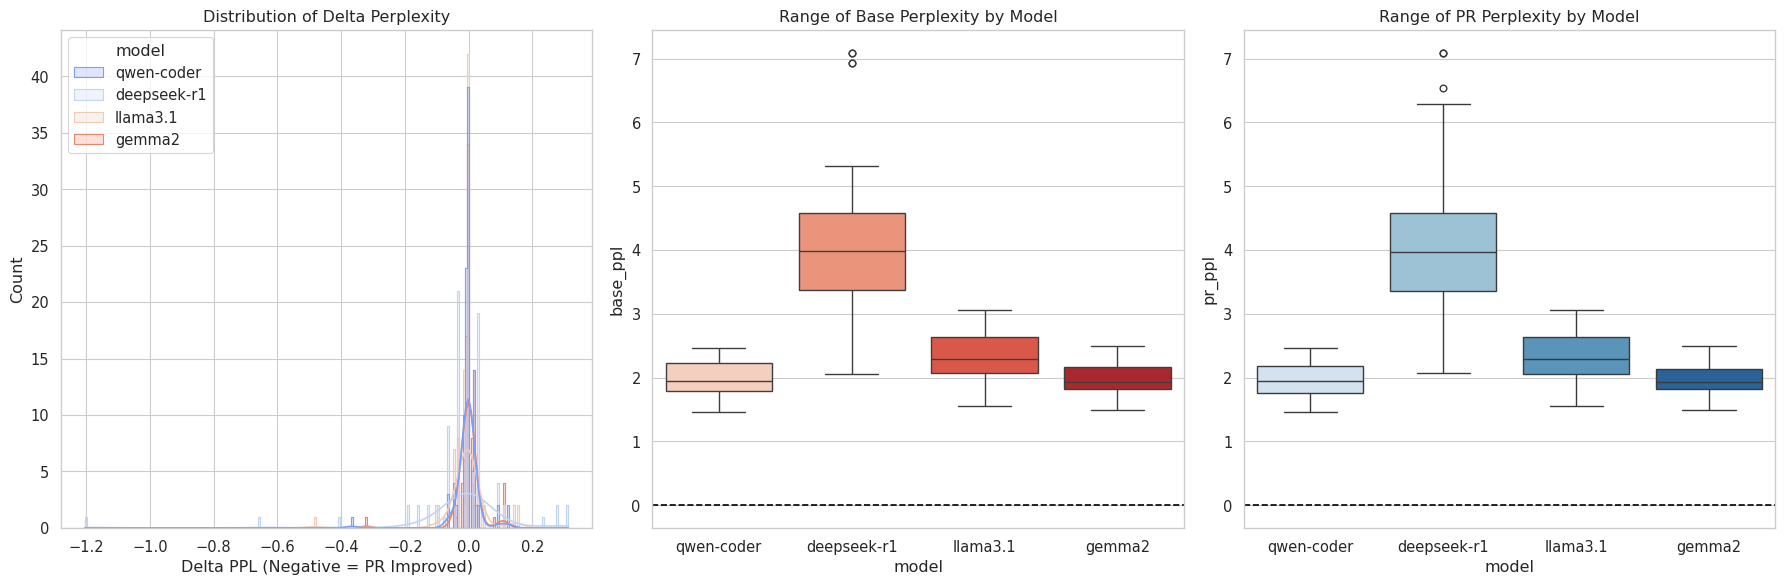

In [70]:
if not df_reports.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.histplot(
        data=df_reports, 
        x='delta_ppl', 
        hue='model', 
        kde=True, 
        element="step", 
        ax=axes[0],
        palette='coolwarm'
    )
    axes[0].set_title('Distribution of Delta Perplexity')
    axes[0].set_xlabel('Delta PPL (Negative = PR Improved)')

    sns.boxplot(
        data=df_reports, 
        x='model', 
        y='base_ppl', 
        hue='model',
        ax=axes[1], 
        palette='Reds',
        #showfliers=False, 
        dodge=False
    )
    axes[1].set_title('Range of Base Perplexity by Model')
    axes[1].axhline(0, color='black', linestyle='--')

    sns.boxplot(
        data=df_reports, 
        x='model', 
        y='pr_ppl', 
        hue='model',
        ax=axes[2], 
        palette='Blues',
        #showfliers=False, 
        dodge=False
    )
    axes[2].set_title('Range of PR Perplexity by Model')
    axes[2].axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()